In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd

In [2]:
# load tracks
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/tcell_tracks.csv"

FRAMES = 5

tracks_df = pd.read_csv(TRACK_PATH)
tracks_df = tracks_df.sort_values(by=["frame"])
tracks_df.drop("Unnamed: 0", axis=1, inplace=True)
tracks_df

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,sd,frame,channel,alive,contact,contacting cell labels,closest cell dist,track_id,id,dist_from_ultrack
0,1,670.849246,390.738693,378,655,25,35,390.738693,670.849246,378.0,...,2274.345323,0,tcell,NaN,True,[30],1.678073,8983,1014979,1.270284
6731,6732,352.354839,255.258065,252,350,7,6,255.258065,352.354839,252.0,...,223.866838,0,tcell,NaN,True,[87],15.890758,6327,1010697,0.438757
6732,6733,558.451613,260.870968,258,556,7,6,260.870968,558.451613,258.0,...,191.854649,0,tcell,NaN,False,[],28.319876,6439,1010789,0.469685
6733,6734,579.451613,264.193548,261,577,7,6,264.193548,579.451613,261.0,...,221.724895,0,tcell,NaN,True,[934],7.115341,5498,1009219,0.491340
6734,6735,175.806452,265.516129,262,173,7,7,265.516129,175.806452,262.0,...,265.453951,0,tcell,NaN,True,[ 36 447],7.636777,6393,1010755,0.551226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000041,1000042,560.065217,993.478261,990,557,8,7,993.478261,560.065217,990.0,...,606.663319,99,tcell,NaN,False,[],15.881903,19838,100034777,0.482687
1000042,1000043,856.565217,994.021739,991,853,8,8,994.021739,856.565217,991.0,...,410.686575,99,tcell,NaN,False,[],39.642860,21506,100035469,0.435326
1000043,1000044,390.444444,2.333333,0,386,6,10,2.333333,390.444444,0.0,...,290.815812,99,tcell,NaN,False,[],14.456091,28562,100000103,0.555556
1000036,1000037,473.521739,977.565217,973,471,10,7,977.565217,473.521739,973.0,...,312.845494,99,tcell,NaN,False,[],22.119762,21379,100028726,0.646351


find duplicates in each frame for each track_id

In [3]:
track_pair_counts = tracks_df.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]
filtered_rows


,frame,track_id,count
0,0,1,2
16,0,24,2
43,0,94,2
47,0,101,2
57,0,119,2
...,...,...,...
963929,99,35432,3
963935,99,35452,2
963946,99,35470,2
963950,99,35478,2


sort values by frame, track_id, dist from ultrack -> remove duplicates per frame and track_id to keep the one with the closer distance to the cellpose label

In [4]:
sorted_df = tracks_df.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df = sorted_df.drop_duplicates(subset=["frame","track_id"], keep="first")
sorted_df

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,sd,frame,channel,alive,contact,contacting cell labels,closest cell dist,track_id,id,dist_from_ultrack
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,231.337425,0,tcell,NaN,False,[],20.487076,1,1000002,0.181818
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,402.733039,0,tcell,NaN,True,[338 750],1.993530,4,1000016,2.544339
4503,4504,66.897436,3.897436,1,64,7,7,3.897436,66.897436,1.0,...,186.240010,0,tcell,NaN,True,[644],3.070972,5,1000018,0.145048
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,539.156821,0,tcell,NaN,True,[463 644],9.164177,6,1000019,0.307318
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,385.188842,0,tcell,NaN,True,[644 750],10.434691,9,1000021,0.357895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997265,997266,251.584906,991.820755,986,247,14,12,991.820755,251.584906,986.0,...,837.834387,99,tcell,NaN,True,[120473],3.226051,35506,100035201,1.912397
1003937,1003938,991.200000,992.266667,990,989,6,6,992.266667,991.200000,990.0,...,220.433077,99,tcell,NaN,True,[121314],5.440465,35507,100035340,0.333333
1004526,1004527,937.964286,988.107143,985,936,7,5,988.107143,937.964286,985.0,...,275.788746,99,tcell,NaN,False,[],25.733965,35510,100035440,0.112938
1006720,1006721,131.600000,992.400000,991,130,4,4,992.400000,131.600000,991.0,...,82.687766,99,tcell,NaN,False,[],41.155410,35511,100035491,0.565685


add tracked frames and tracked length columns to table

In [5]:
sorted_df["tracked frames"] = sorted_df['frame'].groupby(sorted_df['track_id']).transform('count')
sorted_df['tracked length'] = sorted_df.groupby('track_id')['frame'].transform("max") - sorted_df.groupby('track_id')['frame'].transform("min") +1 

sorted_df

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,channel,alive,contact,contacting cell labels,closest cell dist,track_id,id,dist_from_ultrack,tracked frames,tracked length
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,tcell,NaN,False,[],20.487076,1,1000002,0.181818,100,100
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,tcell,NaN,True,[338 750],1.993530,4,1000016,2.544339,97,100
4503,4504,66.897436,3.897436,1,64,7,7,3.897436,66.897436,1.0,...,tcell,NaN,True,[644],3.070972,5,1000018,0.145048,4,4
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,tcell,NaN,True,[463 644],9.164177,6,1000019,0.307318,100,100
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,tcell,NaN,True,[644 750],10.434691,9,1000021,0.357895,57,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997265,997266,251.584906,991.820755,986,247,14,12,991.820755,251.584906,986.0,...,tcell,NaN,True,[120473],3.226051,35506,100035201,1.912397,1,1
1003937,1003938,991.200000,992.266667,990,989,6,6,992.266667,991.200000,990.0,...,tcell,NaN,True,[121314],5.440465,35507,100035340,0.333333,1,1
1004526,1004527,937.964286,988.107143,985,936,7,5,988.107143,937.964286,985.0,...,tcell,NaN,False,[],25.733965,35510,100035440,0.112938,1,1
1006720,1006721,131.600000,992.400000,991,130,4,4,992.400000,131.600000,991.0,...,tcell,NaN,False,[],41.155410,35511,100035491,0.565685,1,1


In [6]:
# filter out short tracks
tracks_df_filtered = sorted_df[sorted_df["tracked length"] > 20]
print(len(tracks_df_filtered["track_id"].unique()))

15083


In [7]:
# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered['mean tracked cell size'] = tracks_df_filtered.groupby("track_id")["size"].transform(mean_transform)
tracks_df_filtered

/tmp/ipykernel_1227414/2716332079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered['mean tracked cell size'] = tracks_df_filtered.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,alive,contact,contacting cell labels,closest cell dist,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,NaN,False,[],20.487076,1,1000002,0.181818,100,100,22.010000
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,NaN,True,[338 750],1.993530,4,1000016,2.544339,97,100,54.814433
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,NaN,True,[463 644],9.164177,6,1000019,0.307318,100,100,55.370000
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,NaN,True,[644 750],10.434691,9,1000021,0.357895,57,57,46.614035
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,NaN,True,[443 499],10.267999,10,1000024,0.500000,25,28,35.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997403,997404,236.385417,968.354167,964,231,10,12,968.354167,236.385417,964.0,...,NaN,False,[],9.095417,32509,100034555,0.523431,21,21,98.428571
1000714,1000715,578.214286,926.000000,923,575,7,8,926.000000,578.214286,923.0,...,NaN,False,[],23.362123,32513,100033454,0.214286,20,21,53.800000
997467,997468,899.076087,930.858696,926,894,12,10,930.858696,899.076087,926.0,...,NaN,True,[120660 120928],4.746183,32515,100034161,0.160487,16,21,145.812500
998802,998803,905.586207,969.913793,965,901,10,10,969.913793,905.586207,965.0,...,NaN,True,[120179],7.198675,32519,100034140,0.422678,21,21,60.952381


In [8]:
area_percentiles = tracks_df_filtered.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

area_percentiles


105.20408163265306

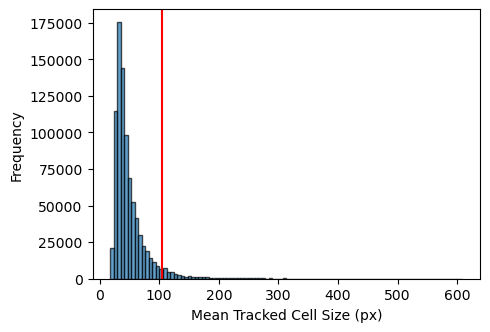

In [9]:
fig, axs = plt.subplots(1,1,figsize=(5,3.5))

tracks_df_filtered['mean tracked cell size'].plot(kind='hist', bins=100, edgecolor='black', alpha=0.7, ax=axs)
axs.set_xlabel("Mean Tracked Cell Size (px)")

axs.axvline(x=area_percentiles,c="r")

In [10]:
# filter out the cells with average area larger than threshold
tracks_df_filtered = tracks_df_filtered[tracks_df_filtered["mean tracked cell size"]<area_percentiles]
tracks_df_filtered

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,alive,contact,contacting cell labels,closest cell dist,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,NaN,False,[],20.487076,1,1000002,0.181818,100,100,22.010000
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,NaN,True,[338 750],1.993530,4,1000016,2.544339,97,100,54.814433
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,NaN,True,[463 644],9.164177,6,1000019,0.307318,100,100,55.370000
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,NaN,True,[644 750],10.434691,9,1000021,0.357895,57,57,46.614035
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,NaN,True,[443 499],10.267999,10,1000024,0.500000,25,28,35.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003010,1003011,118.575758,919.424242,917,116,6,6,919.424242,118.575758,917.0,...,NaN,False,[],19.545513,32506,100033502,0.599969,21,21,37.523810
997403,997404,236.385417,968.354167,964,231,10,12,968.354167,236.385417,964.0,...,NaN,False,[],9.095417,32509,100034555,0.523431,21,21,98.428571
1000714,1000715,578.214286,926.000000,923,575,7,8,926.000000,578.214286,923.0,...,NaN,False,[],23.362123,32513,100033454,0.214286,20,21,53.800000
998802,998803,905.586207,969.913793,965,901,10,10,969.913793,905.586207,965.0,...,NaN,True,[120179],7.198675,32519,100034140,0.422678,21,21,60.952381


## Kinematics Measurements

In [11]:
# # displacement
diff = tracks_df_filtered.groupby("track_id")[["x","y","frame"]].diff()
tracks_df_filtered["dx from previous point"] = diff["x"].fillna(0)
tracks_df_filtered["dy from previous point"] = diff["y"].fillna(0)
tracks_df_filtered["displacement from previous point"] = np.linalg.norm(tracks_df_filtered[["dx from previous point","dy from previous point"]], axis=1)

tracks_df_filtered["dx from origin"] = tracks_df_filtered.groupby(['track_id'])['dx from previous point'].cumsum().fillna(0)
tracks_df_filtered["dy from origin"] = tracks_df_filtered.groupby(['track_id'])['dy from previous point'].cumsum().fillna(0)
tracks_df_filtered["displacement from origin"] = np.linalg.norm(tracks_df_filtered[["dx from origin","dy from origin"]], axis=1)
tracks_df_filtered["dx acc"] = diff["x"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered["dy acc"] = diff["y"].apply(lambda x: abs(x)).fillna(0) # abs displacement
tracks_df_filtered["dx acc"] = tracks_df_filtered.groupby(['track_id'])['dx acc'].cumsum()
tracks_df_filtered["dy acc"] = tracks_df_filtered.groupby(['track_id'])['dy acc'].cumsum()
tracks_df_filtered["distance travelled"] = tracks_df_filtered.groupby(['track_id'])['displacement from previous point'].cumsum()


# velocity
tracks_df_filtered["vel_x"] = (diff["x"]/diff["frame"]).fillna(0)
tracks_df_filtered["vel_y"] = (diff["y"]/diff["frame"]).fillna(0)
tracks_df_filtered["speed"] = (np.linalg.norm(diff[["x","y"]], axis=1)/diff['frame']).fillna(0)

# TODO: Track tortuosity

tracks_df_filtered

/tmp/ipykernel_1227414/826376286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered["dx from previous point"] = diff["x"].fillna(0)
/tmp/ipykernel_1227414/826376286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered["dy from previous point"] = diff["y"].fillna(0)
/tmp/ipykernel_1227414/826376286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,displacement from previous point,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003010,1003011,118.575758,919.424242,917,116,6,6,919.424242,118.575758,917.0,...,0.291244,0.324242,-1.190909,1.234260,6.654060,4.179335,8.810814,0.289107,0.035217,0.291244
997403,997404,236.385417,968.354167,964,231,10,12,968.354167,236.385417,964.0,...,0.309517,-1.773106,-1.341856,2.223619,14.676895,8.877486,19.035586,-0.085394,0.297505,0.309517
1000714,1000715,578.214286,926.000000,923,575,7,8,926.000000,578.214286,923.0,...,0.423478,-5.482759,9.024631,10.559574,11.119242,12.202855,17.805729,-0.276596,0.320669,0.423478
998802,998803,905.586207,969.913793,965,901,10,10,969.913793,905.586207,965.0,...,0.124329,1.566854,1.933146,2.488390,3.246259,3.876335,5.413220,0.103448,-0.068966,0.124329


In [91]:
msd_df = tracks_df_filtered[["label","x","y","track_id", "frame", "dx from previous point", "dy from previous point", "displacement from previous point"]]

msd_df["msd"] = (msd_df["dx from previous point"]**2 + msd_df["dy from previous point"]**2).mean()

msd_df

/tmp/ipykernel_1227414/2644454907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msd_df["msd"] = (msd_df["dx from previous point"]**2 + msd_df["dy from previous point"]**2).mean()


,label,x,y,track_id,frame,dx from previous point,dy from previous point,displacement from previous point,msd
9160,9161,1.181818,21.000000,1,0,0.000000,0.000000,0.000000,0.939453
419,420,6.090164,46.549180,4,0,0.000000,0.000000,0.000000,0.939453
1934,1935,11.933333,61.300000,6,0,0.000000,0.000000,0.000000,0.939453
699,700,5.000000,57.642105,9,0,0.000000,0.000000,0.000000,0.939453
9495,9496,1.500000,95.000000,10,0,0.000000,0.000000,0.000000,0.939453
...,...,...,...,...,...,...,...,...,...
1003010,1003011,919.424242,118.575758,32506,99,0.289107,0.035217,0.291244,0.939453
997403,997404,968.354167,236.385417,32509,99,-0.085394,0.297505,0.309517,0.939453
1000714,1000715,926.000000,578.214286,32513,99,-0.276596,0.320669,0.423478,0.939453
998802,998803,969.913793,905.586207,32519,99,0.103448,-0.068966,0.124329,0.939453


In [53]:
# Function to calculate MSD
def calculate_msd(cell_data):
    dx = cell_data["dx from previous point"] = diff["x"].fillna(0)
    dy = cell_data["dy from previous point"] = diff["y"].fillna(0)
    msd = (dx**2 + dy**2).mean()
    return msd

In [85]:
# Calculate MSD for each cell track
msd_data = []
cell_id = 32541

#cell_data = msd_df[msd_df['track_id'] == cell_id]


for cell_id in range(10):

    cell_data = msd_df.loc[msd_df['track_id'] == cell_id]

    # Calculate MSD for each timepoint
    msd_values = cell_data.groupby('frame').apply(calculate_msd)

    # Add cell ID to the result
    msd_values['track_id'] = cell_id

    msd_data.append(msd_values)

msd_df = pd.concat(msd_data)
msd_df_

/tmp/ipykernel_1227414/3122209199.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  msd_values = cell_data.groupby('frame').apply(calculate_msd)
/tmp/ipykernel_1227414/3122209199.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  msd_values = cell_data.groupby('frame').apply(calculate_msd)


,label,x,y,track_id,frame,dx from previous point,dy from previous point,displacement from previous point,0
frame,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
...,...,...,...,...,...,...,...,...,...
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.939453


KeyError: 'msd'

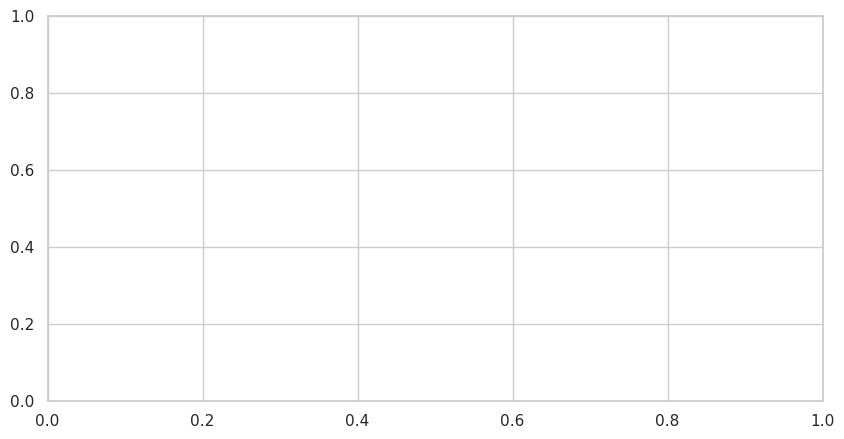

In [86]:
track_id = cell_id

fig, axs = plt.subplots(1,1,figsize=(10,5))

single_cell_df = msd_df.loc[msd_df["track_id"]==track_id]
single_cell_df = single_cell_df.sort_values(by=["frame"])
axs.plot(single_cell_df['frame'], single_cell_df['msd'], label=track_id)
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1671.37it/s]


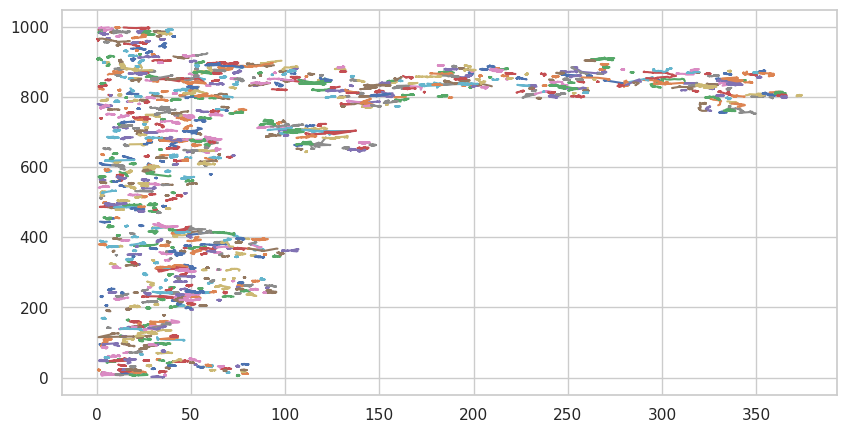

In [90]:
track_id = 10

fig, axs = plt.subplots(1,1,figsize=(10,5))

for t_id in tqdm(range(2000)):
    single_cell_df = msd_df.loc[msd_df["track_id"]==t_id]
    single_cell_df = single_cell_df.sort_values(by=["frame"])
    axs.plot(single_cell_df['x'], single_cell_df['y'], label=track_id)
  


## Diffusion Measurements

### Displacements vs Travelled Distances

100%|██████████| 10/10 [00:00<00:00, 186.92it/s]


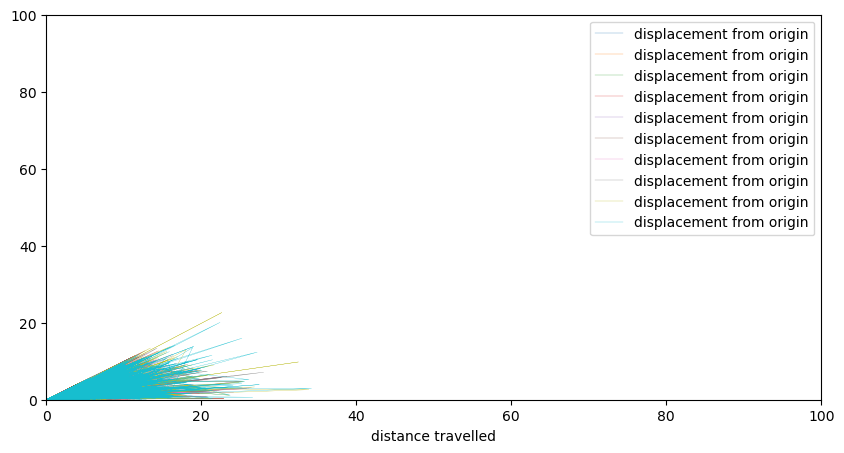

In [77]:
from tqdm import tqdm

fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.set_xlim(0,100)
axs.set_ylim(0,100)

for t in tqdm(range(10)):
    tracks_df_filtered_ = tracks_df_filtered[tracks_df_filtered["frame"] == t]
    tracks_df_filtered_.plot("distance travelled","displacement from origin",ax=axs,lw=0.2)

# axs.get_legend().remove()

Text(0, 0.5, 'Frequency')

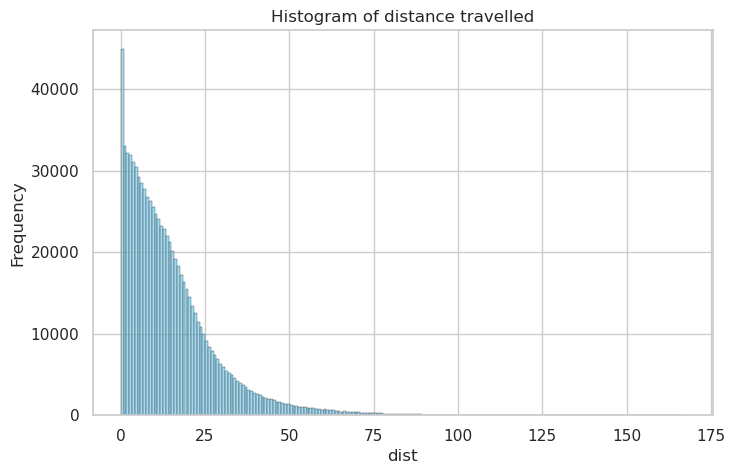

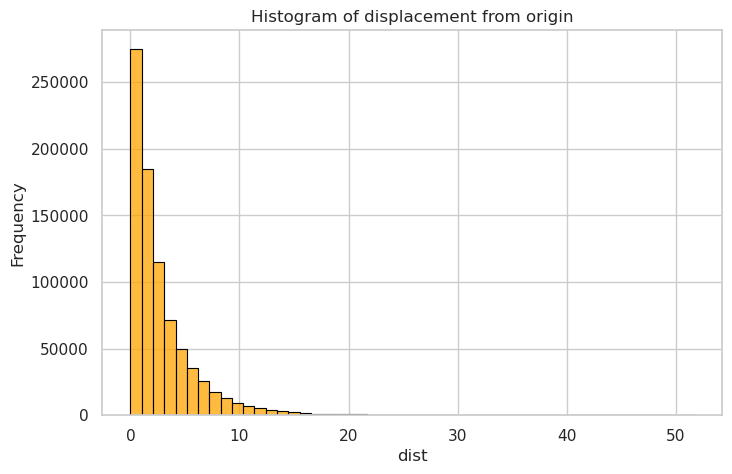

In [84]:
import seaborn as sns

#axs.set_xlim(0,3)
#axs.set_ylim(0,125)
# Set Seaborn style
sns.set(style='whitegrid')

# Plot a histogram
plt.figure(figsize=(8, 5)) 
sns.histplot(data=tracks_df_filtered, x='distance travelled', bins=200, kde=False, color='skyblue', edgecolor='black')
plt.title('Histogram of distance travelled')
plt.xlabel('dist')
plt.ylabel('Frequency')

# Plot a histogram
plt.figure(figsize=(8, 5))
sns.histplot(data=tracks_df_filtered, x="displacement from origin", bins=50, kde=False, color='orange', edgecolor='black')
plt.title('Histogram of displacement from origin')
plt.xlabel('dist')
plt.ylabel('Frequency') 



## Simple Contact Count

In [13]:
contact_df = tracks_df_filtered.groupby('track_id')["contact"].sum()
contact_df

track_id
1          0
2         93
3         29
4         97
6        100
        ... 
32506      0
32509      0
32513     14
32519     21
32541      0
Name: contact, Length: 13293, dtype: int64

Text(0.5, 0, 'Contact #')

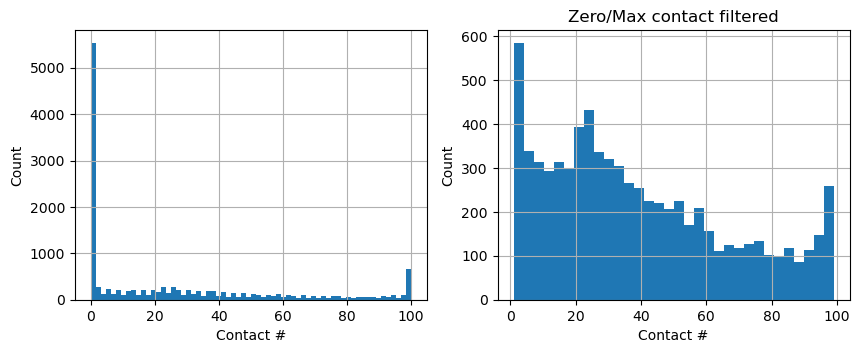

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,3.5))
contact_df.hist(bins=64,ax=axs[0])
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Contact #")

axs[1].set_title("Zero/Max contact filtered")
contact_df[(contact_df>0) & (contact_df!=100)].hist(bins=32,ax=axs[1])
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Contact #")

## Mutiple Contact Count
We count the acccumulated number of cells that T cells were in contact with.

In [12]:
def contact_count_helper(x):
    if  x =="[]":
        return 0
    else:
        return len(x.split(" "))

tracks_df_filtered_ = tracks_df_filtered
tracks_df_filtered_["instanenous cell contacts"] = tracks_df_filtered_["contacting cell labels"].apply(lambda x: contact_count_helper(x))

tracks_df_filtered_

/tmp/ipykernel_1227414/4205577454.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_["instanenous cell contacts"] = tracks_df_filtered_["contacting cell labels"].apply(lambda x: contact_count_helper(x))


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,dx from origin,dy from origin,displacement from origin,dx acc,dy acc,distance travelled,vel_x,vel_y,speed,instanenous cell contacts
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003010,1003011,118.575758,919.424242,917,116,6,6,919.424242,118.575758,917.0,...,0.324242,-1.190909,1.234260,6.654060,4.179335,8.810814,0.289107,0.035217,0.291244,0
997403,997404,236.385417,968.354167,964,231,10,12,968.354167,236.385417,964.0,...,-1.773106,-1.341856,2.223619,14.676895,8.877486,19.035586,-0.085394,0.297505,0.309517,0
1000714,1000715,578.214286,926.000000,923,575,7,8,926.000000,578.214286,923.0,...,-5.482759,9.024631,10.559574,11.119242,12.202855,17.805729,-0.276596,0.320669,0.423478,0
998802,998803,905.586207,969.913793,965,901,10,10,969.913793,905.586207,965.0,...,1.566854,1.933146,2.488390,3.246259,3.876335,5.413220,0.103448,-0.068966,0.124329,1


In [13]:
multi_contact_df = tracks_df_filtered_.groupby('track_id')["instanenous cell contacts"].sum()
multi_contact_df

track_id
1          0
2        161
3         40
4         98
6        227
        ... 
32506      0
32509      0
32513     14
32519     21
32541      0
Name: instanenous cell contacts, Length: 13293, dtype: int64

Text(0.5, 0, 'Total Cell Contact #')

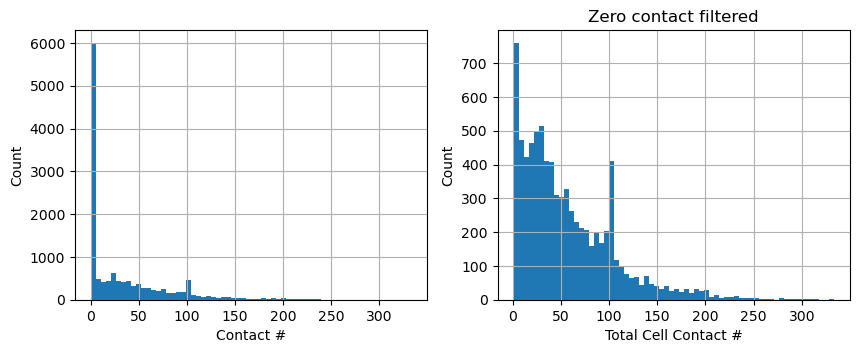

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,3.5))
multi_contact_df.hist(bins=64,ax=axs[0])
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Contact #")

axs[1].set_title("Zero contact filtered")
multi_contact_df[(multi_contact_df>0)].hist(bins=64,ax=axs[1])
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Total Cell Contact #")

## Save filtered tracks

In [15]:
# save tracks
tracks_df_filtered.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/Tcell_tracks/tracks/tcell_tracks_filtered.csv")